# A guide Portfolio Optimization

This notebook aims to provide an example of using PortfolioOptimizationEnv (or POE) and [RLPortfolio](https://github.com/CaioSBC/RLPortfolio) to train a reinforcement learning model that learns to solve the portfolio optimization problem.

In this document, we will train an agent that implements a famous architecture called EIIE (ensemble of identical independent evaluators), introduced in the following paper:

- Zhengyao Jiang, Dixing Xu, & Jinjun Liang. (2017). A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem. https://doi.org/10.48550/arXiv.1706.10059.

It's advisable to read it to understand the algorithm implemented in this notebook.

### Note
If you're using POE or [RLPortfolio](https://github.com/CaioSBC/RLPortfolio), consider citing the library and the following paper (in adittion to FinRL references):

- Caio Costa, & Anna Costa (2023). POE: A General Portfolio Optimization Environment for FinRL. In *Anais do II Brazilian Workshop on Artificial Intelligence in Finance* (pp. 132–143). SBC. https://doi.org/10.5753/bwaif.2023.231144.

```
@inproceedings{bwaif,
 author = {Caio Costa and Anna Costa},
 title = {POE: A General Portfolio Optimization Environment for FinRL},
 booktitle = {Anais do II Brazilian Workshop on Artificial Intelligence in Finance},
 location = {João Pessoa/PB},
 year = {2023},
 keywords = {},
 issn = {0000-0000},
 pages = {132--143},
 publisher = {SBC},
 address = {Porto Alegre, RS, Brasil},
 doi = {10.5753/bwaif.2023.231144},
 url = {https://sol.sbc.org.br/index.php/bwaif/article/view/24959}
}

```

## Installation and imports

To run this notebook in google colab, uncomment the cells below.

In [1]:
## install finrl library
# !sudo apt install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [2]:
## Hide matplotlib warnings
# import warnings
# warnings.filterwarnings('ignore')

import logging

logging.getLogger("matplotlib.font_manager").disabled = True

#### Import the necessary code libraries

In [3]:
import torch

import pandas as pd

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.rlportfolio.models import DRLAgent

device = "cuda" if torch.cuda.is_available() else "cpu"

## Fetch data

In his paper, *Jiang et al* creates a portfolio composed of 11 cryptocurrencies. In order to show that Jiang's approach can be applied to other financial markets, we utilize a different portfolio of 11 stocks from the American stock market (NYSE). The dataset we will utilize in this experiment can be downloaded from kaggle.

In [4]:
# Note: If you have already downloaded the stock data, comment this cell!
# !curl -L -o us-historical-stock-prices-with-earnings-data.zip https://www.kaggle.com/api/v1/datasets/download/tsaustin/us-historical-stock-prices-with-earnings-data
# !unzip us-historical-stock-prices-with-earnings-data.zip stocks_latest/stock_prices_latest.csv
# !mv stocks_latest/stock_prices_latest.csv .
# !rm -r stocks_latest/
# !rm us-historical-stock-prices-with-earnings-data.zip

In [5]:
IBOVESPA_STOCKS = ["VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "RENT3.SA", "LREN3.SA", "PRIO3.SA",
    "WEGE3.SA", "ABEV3.SA"]

In [6]:
print(len(IBOVESPA_STOCKS))

portfolio_raw_df = YahooDownloader(start_date = '2011-01-01',
                                end_date = '2023-12-31',
                                ticker_list = IBOVESPA_STOCKS).fetch_data()
portfolio_raw_df

10


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (32260, 8)


Price,date,close,high,low,open,volume,tic,day
0,2011-01-03,5.110479,8.728203,8.630313,8.632311,576145,ABEV3.SA,0
1,2011-01-03,6.060575,15.900000,15.690000,15.750000,6626800,BBAS3.SA,0
2,2011-01-03,6.065994,11.927362,11.724237,11.809763,10862336,BBDC4.SA,0
3,2011-01-03,10.159506,18.250118,17.963253,18.031555,10014663,ITUB4.SA,0
4,2011-01-03,5.395488,7.845370,7.656995,7.656995,4017796,LREN3.SA,0
...,...,...,...,...,...,...,...,...
32255,2023-12-28,30.414377,37.360001,37.040001,37.230000,21421900,PETR4.SA,3
32256,2023-12-28,46.049999,46.049999,45.320000,45.820000,7871200,PRIO3.SA,3
32257,2023-12-28,61.143093,63.900002,63.209999,63.450001,3404700,RENT3.SA,3
32258,2023-12-28,70.659607,77.459999,76.750000,77.000000,16545800,VALE3.SA,3


In [7]:
portfolio_raw_df.groupby("tic").count()

Price,date,close,high,low,open,volume,day
tic,,,,,,,
ABEV3.SA,3226,3226,3226,3226,3226,3226,3226
BBAS3.SA,3226,3226,3226,3226,3226,3226,3226
BBDC4.SA,3226,3226,3226,3226,3226,3226,3226
ITUB4.SA,3226,3226,3226,3226,3226,3226,3226
LREN3.SA,3226,3226,3226,3226,3226,3226,3226
PETR4.SA,3226,3226,3226,3226,3226,3226,3226
PRIO3.SA,3226,3226,3226,3226,3226,3226,3226
RENT3.SA,3226,3226,3226,3226,3226,3226,3226
VALE3.SA,3226,3226,3226,3226,3226,3226,3226


In [8]:
df_portfolio = portfolio_raw_df[["date", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[
    (df_portfolio["date"] >= "2011-01-01") & (df_portfolio["date"] < "2019-12-31")
]
df_portfolio_2020 = df_portfolio[
    (df_portfolio["date"] >= "2019-10-16") & (df_portfolio["date"] < "2020-12-31")
]

### Instantiate Environment

Using the `PortfolioOptimizationEnv`, it's easy to instantiate a portfolio optimization environment for reinforcement learning agents. In the example below, we use the dataframe created before to start an environment.

We create an environment to with data from 2011 to 2019 which will be used to train the agent and another one with data of 2020, which will be used to test the environment.

**Note:** Since the agent visualizes 50 temporal points in the past to choose its action, the dataframe used in the 2020 environment starts in 2019-10-16 so that the agent can take its first action in the first day of 2020. If the dataframe only contained data from 2020, the agent would only be able to start the portfolio optimization after 50 trading days have passed.

In [9]:
environment = PortfolioOptimizationEnv(
    df_portfolio_train,
    initial_amount=100000,
    state_normalization="by_last_close",
    comission_fee_pct=0.0025,
    time_window=50,
    time_format="%Y-%m-%d",
    tic_column="tic",
    features=["close", "high", "low"],
    print_metrics=False,
    plot_graphs=False,
)

environment_2020 = PortfolioOptimizationEnv(
    df_portfolio_2020,
    initial_amount=100000,
    state_normalization="by_last_close",
    comission_fee_pct=0.0025,
    time_window=50,
    time_format="%Y-%m-%d",
    tic_column="tic",
    features=["close", "high", "low"],
    print_metrics=False,
    plot_graphs=False,
)

### Instantiate Model

Now, we can instantiate the model using FinRL API. In this example, we are going to use the EIIE architecture introduced by Jiang et. al.

:exclamation: **Note:** Remember to set the policy's `time_window` parameter with the same value of the environment's `time_window`.

In [10]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 5e-5,
    "sample_bias": 0.001,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "time_window": 50,
}

model = DRLAgent(environment).get_model(
    "pg", "eiie", model_kwargs, policy_kwargs, device
)

### Train Model

In [11]:
DRLAgent.train_model(
    model, 200000, logging_period=20000, val_env=environment_2020, val_gradient_steps=30
)

Completed: 100%|█| 200000/200000 [16:40<00:00, 199.91step/s, fapv=4.53e+3, mdd=-


### Save Model

In [12]:
torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

## Test Model

### Test EIIE architecture

It is possible to visualize the performance of the EIIE architecture by acessing data saved from the environment.

In [13]:
EIIE_results = {
    "training": environment._asset_memory["final"],
    "2020": environment_2020._asset_memory["final"],
}

### Test Uniform Buy and Hold
For comparison, we will also test the performance of a uniform buy and hold strategy. In this strategy, the portfolio has no remaining cash and the same percentage of money is allocated in each asset.

In [14]:
UBAH_results = {}

PORTFOLIO_SIZE = len(IBOVESPA_STOCKS)

# train period
terminated = False
environment.reset()
action = None
while not terminated:
    if action is None:
        action = [0] + [1 / PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    else:
        action = environment._final_weights[-1]
    _, _, terminated, _, _ = environment.step(action)
UBAH_results["training"] = environment._asset_memory["final"]

# 2020
terminated = False
environment_2020.reset()
action = None
while not terminated:
    if action is None:
        action = [0] + [1 / PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    else:
        action = environment_2020._final_weights[-1]
    _, _, terminated, _, _ = environment_2020.step(action)
UBAH_results["2020"] = environment_2020._asset_memory["final"]

### Best Stock
We will also compare with a benchmark: what if the agent invested everything in the best performing stock of the test period? This benchmark is not realistic, since the agent would need to have information about the feature.

In [15]:
best_stock_results = {}

# 2020
terminated = False
environment_2020.reset()
while not terminated:
    action = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    _, _, terminated, _, _ = environment_2020.step(action)
best_stock_results["2020"] = environment_2020._asset_memory["final"]

### Plot graphics

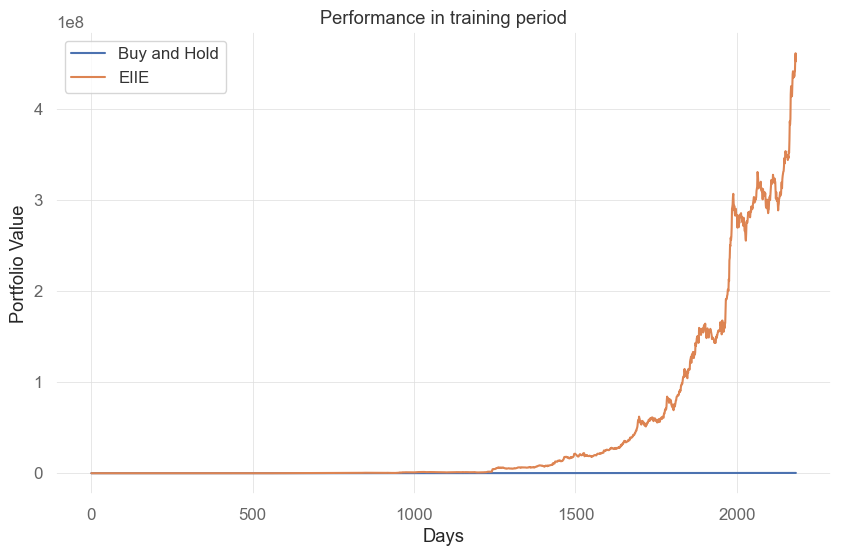

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["training"], label="Buy and Hold")
plt.plot(EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

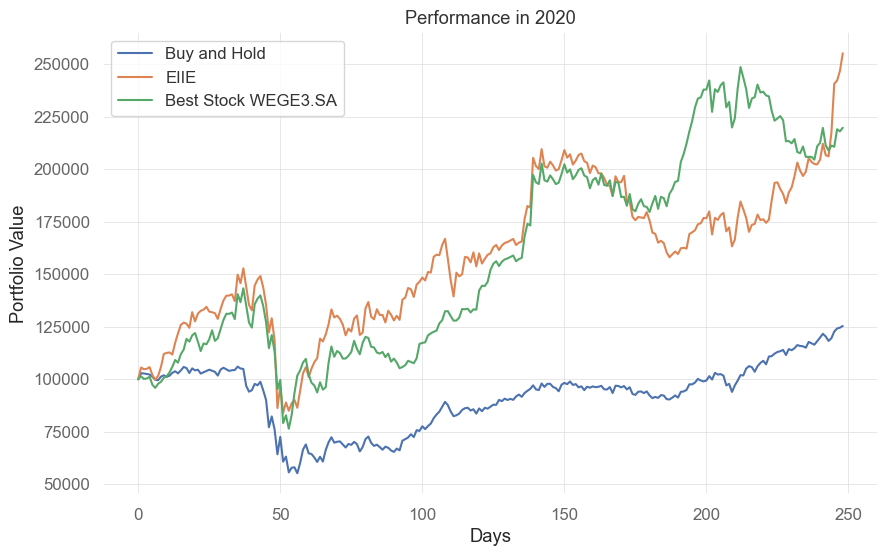

In [17]:
plt.plot(UBAH_results["2020"], label="Buy and Hold")
plt.plot(EIIE_results["2020"], label="EIIE")
plt.plot(best_stock_results["2020"], label="Best Stock WEGE3.SA")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2020")
plt.legend()

plt.show()

The agent successfully learned a policy that outperformed the uniform buy-and-hold strategy and 